In [2]:
!pip install --upgrade pip
!pip install opencv-python pypdf2

Requirement already up-to-date: pip in /home/nbcommon/anaconda2_410/lib/python2.7/site-packages


In [3]:
!curl -LOk https://github.com/Doozeer/PGC/raw/master/test0.pdf
!curl -LOk https://github.com/Doozeer/PGC/raw/master/5%20matematica_bloco1%205ef_Combine.pdf
!ls -l

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   128  100   128    0     0    676      0 --:--:-- --:--:-- --:--:--   680
100  639k  100  639k    0     0  1327k      0 --:--:-- --:--:-- --:--:-- 1327k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   158  100   158    0     0    577      0 --:--:-- --:--:-- --:--:--   578
100 1643k  100 1643k    0     0  2483k      0 --:--:-- --:--:-- --:--:-- 7818k
total 2284
-rw-r--r-- 1 nbuser nbuser 1683148 Apr  2 22:53 5%20matematica_bloco1%205ef_Combine.pdf
lrwxrwxrwx 1 nbuser nbuser      28 Apr  2 15:02 anaconda2_410 -> /home/nbcommon/anaconda2_410
lrwxrwxrwx 1 nbuser nbuser      28 Apr  2 15:02 anaconda3_410 -> /home/nbcommon/anaconda3_410
-rw-r--r-- 1 nbuser nbuser  654695 Apr  2 22:53 test0.pdf


In [131]:
import struct
import math
import cv2
import PyPDF2 as pypdf
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import platform
import sklearn
import random as rnd
print "      Python version: {}".format(platform.python_version())
print "      OpenCV version: {}".format(cv2.__version__)
print "     PyPDF2 version : {}".format(pypdf.__version__)
print "Scikit-learn version: {}".format(sklearn.__version__)

      Python version: 2.7.11
      OpenCV version: 3.2.0
     PyPDF2 version : 1.26.0
Scikit-learn version: 0.17.1


In [132]:
try:
    CV_CUR_LOAD_IM_GRAY = cv2.CV_LOAD_IMAGE_GRAYSCALE
except AttributeError:
    CV_CUR_LOAD_IM_GRAY = cv2.IMREAD_GRAYSCALE

def tiff_header_for_CCITT(width, height, img_size, CCITT_group=4):
    tiff_header_struct = '<' + '2s' + 'h' + 'l' + 'h' + 'hhll' * 8 + 'h'
    return struct.pack(tiff_header_struct,
                       b'II',  # Byte order indication: Little indian
                       42,  # Version number (always 42)
                       8,  # Offset to first IFD
                       8,  # Number of tags in IFD
                       256, 4, 1, width,  # ImageWidth, LONG, 1, width
                       257, 4, 1, height,  # ImageLength, LONG, 1, lenght
                       258, 3, 1, 1,  # BitsPerSample, SHORT, 1, 1
                       259, 3, 1, CCITT_group,  # Compression, SHORT, 1, 4 = CCITT Group 4 fax encoding
                       262, 3, 1, 0,  # Threshholding, SHORT, 1, 0 = WhiteIsZero
                       273, 4, 1, struct.calcsize(tiff_header_struct),  # StripOffsets, LONG, 1, len of header
                       278, 4, 1, height,  # RowsPerStrip, LONG, 1, lenght
                       279, 4, 1, img_size,  # StripByteCounts, LONG, 1, size of image
                       0  # last IFD
                       )

def handleCCITTFaxDecodeImg(obj):
    if obj['/DecodeParms']['/K'] == -1:
        CCITT_group = 4
    else:
        CCITT_group = 3
    width = obj['/Width']
    height = obj['/Height']
    data = obj._data  # sorry, getData() does not work for CCITTFaxDecode
    img_size = len(data)
    tiff_header = tiff_header_for_CCITT(width, height, img_size, CCITT_group)
    data = tiff_header + data
    return cv2.imdecode(np.frombuffer(data, np.uint8), CV_CUR_LOAD_IM_GRAY)

def handleOtherImg(obj):
    data = obj._data
    return 255-cv2.imdecode(np.frombuffer(data, np.uint8), CV_CUR_LOAD_IM_GRAY)

def getImgFromPage(pdfObj, page):
    colorSpaceDict = {}
    pageObj = pdfObj.getPage(page)
    xObj = pageObj['/Resources']['/XObject'].getObject()
    for obj in xObj:
        if xObj[obj]['/Subtype'] == '/Image':
            if xObj[obj]['/Filter'] == '/CCITTFaxDecode':
                return handleCCITTFaxDecodeImg(xObj[obj])
            else:
                return handleOtherImg(xObj[obj])

def getImagesFromPDF(filePath):
    pdfObj = pypdf.PdfFileReader(open(filePath, "rb"))
    nPages = pdfObj.getNumPages()
    images = [getImgFromPage(pdfObj, page) for page in range(nPages)]
    return images

def scharrGradient(image):
    # compute the Scharr gradient magnitude representation of the images
    # in both the x and y direction
    gradX = cv2.Scharr(image, ddepth = cv2.CV_32F, dx = 1, dy = 0)
    gradY = cv2.Scharr(image, ddepth = cv2.CV_32F, dx = 0, dy = 1)
    # subtract the y-gradient from the x-gradient
    gradient = cv2.subtract(gradX, gradY)
    gradient = cv2.convertScaleAbs(gradient)
    return gradient

def otsuBinary(image):
    # Otsu's thresholding after Gaussian filtering
    blurred = cv2.GaussianBlur(image,(5,5),0)
    threshVal, threshImg = cv2.threshold(blurred,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return threshImg

def morphClose(image, kernelSize):
    # construct a closing kernel and apply it to the thresholded image
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize)
    closed = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    return closed

def imshow(data, cmap=None):
    pltFigSize = (20, 20)
    #data = data[310:425, 1475:2055]
    fig = plt.figure(figsize=pltFigSize)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(data, cmap=cmap)
    plt.show()

In [133]:
images = getImagesFromPDF('test0.pdf')

# Referência para próxima parte:
http://www.pyimagesearch.com/2014/11/24/detecting-barcodes-images-python-opencv/

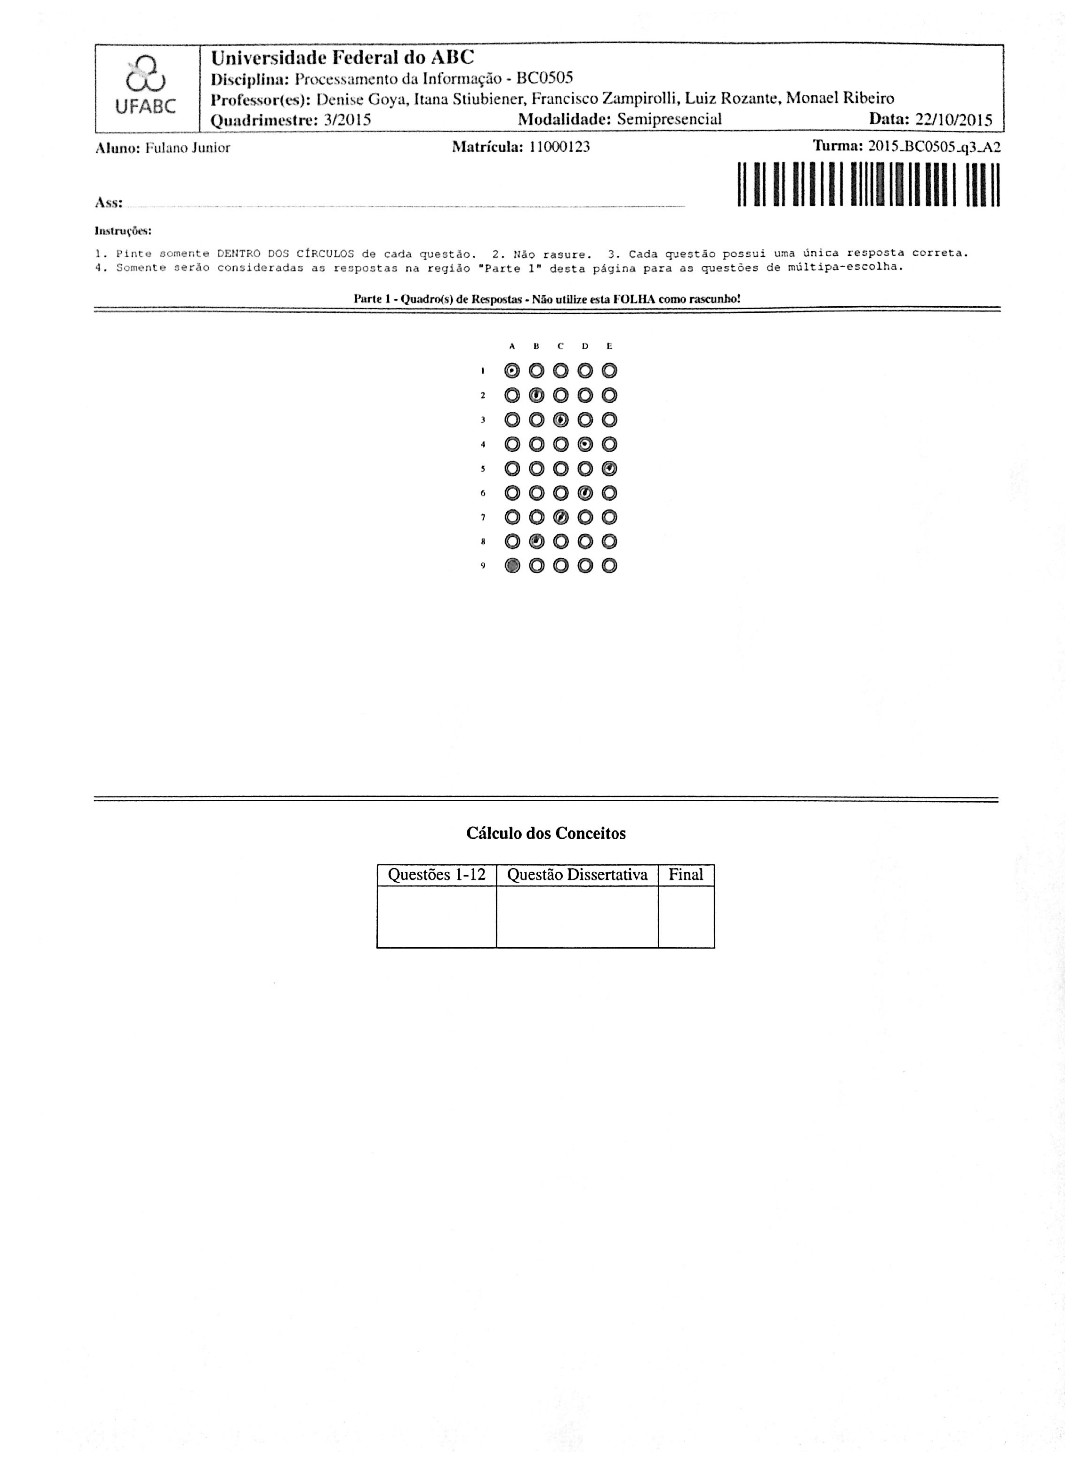

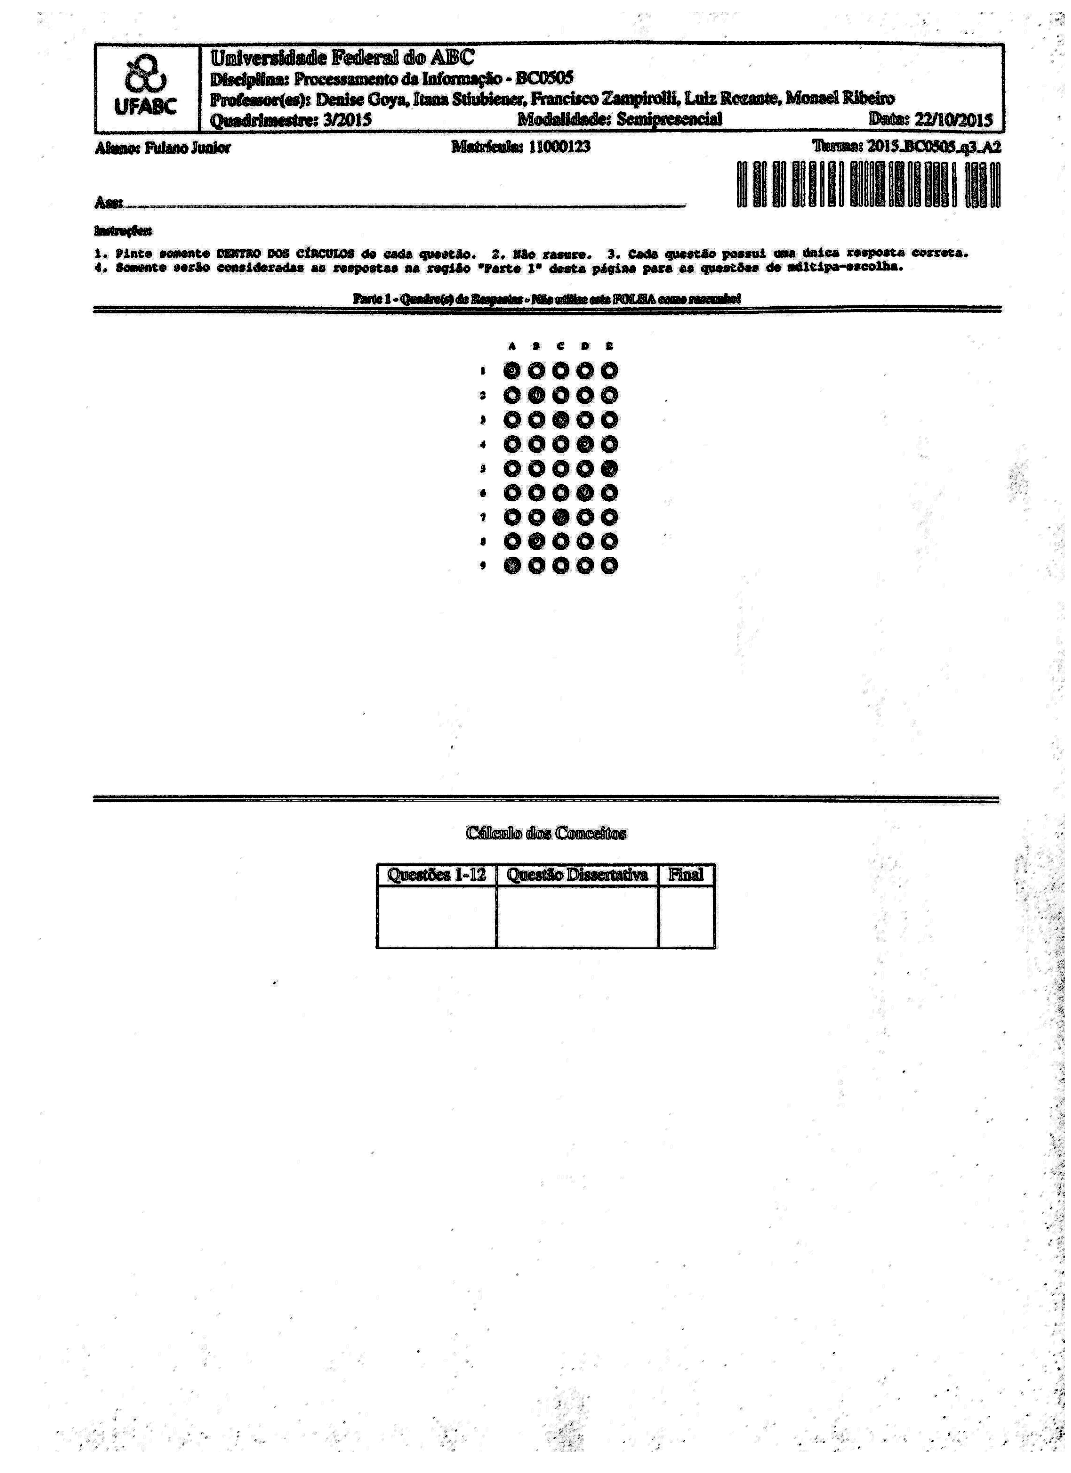

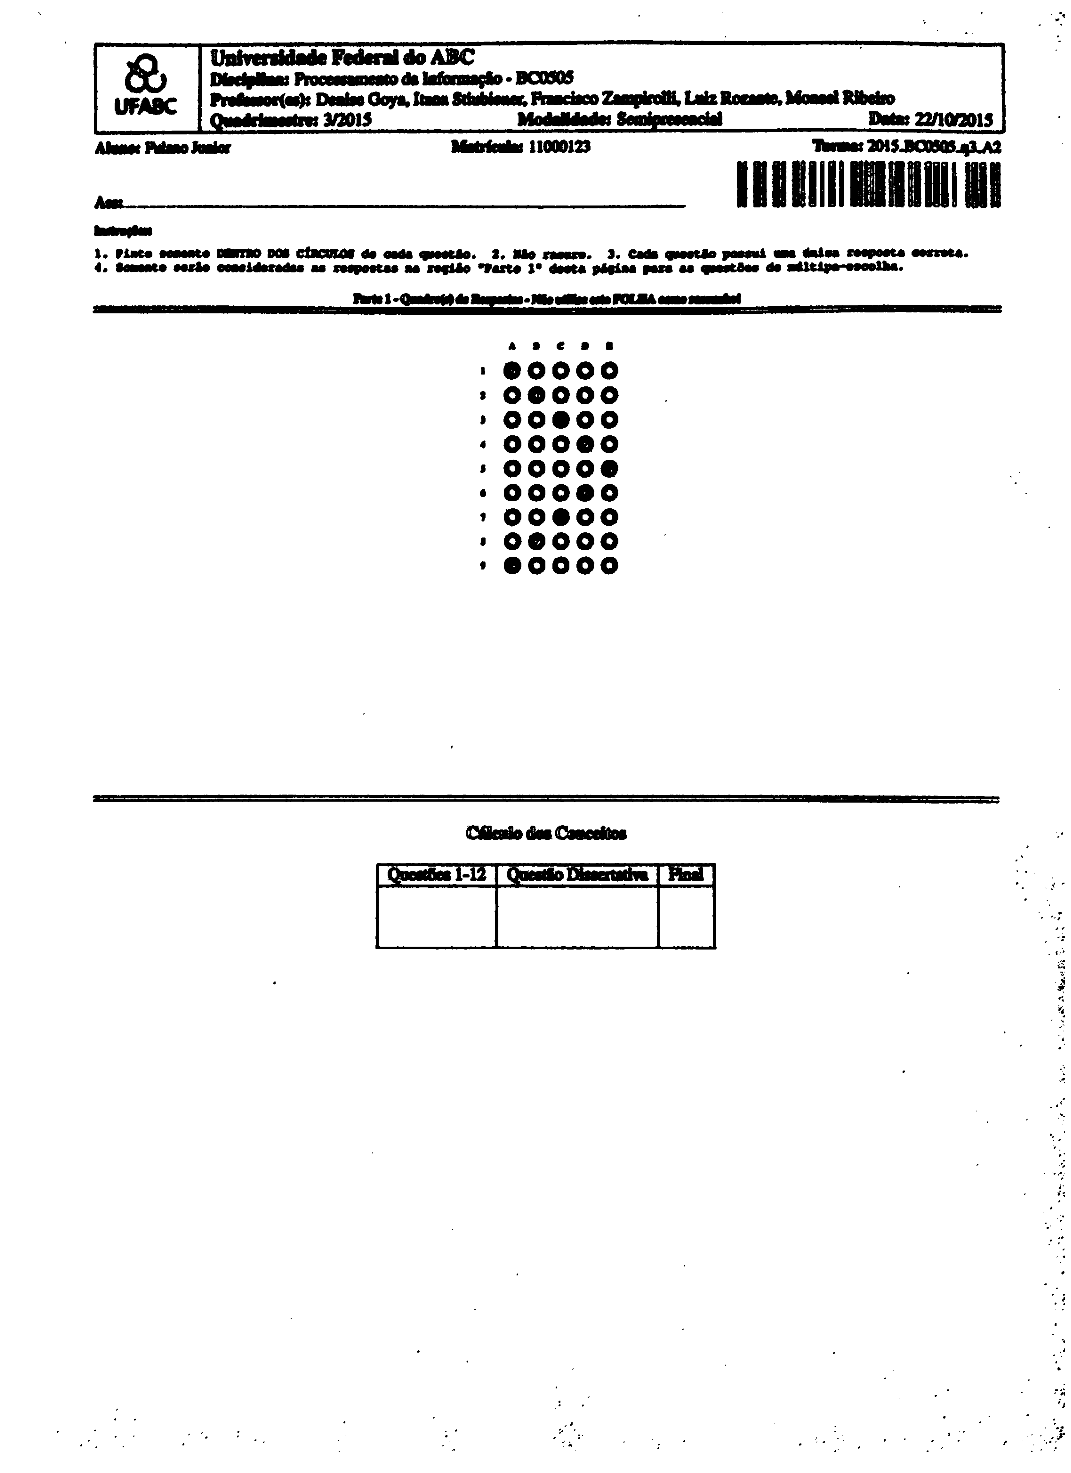

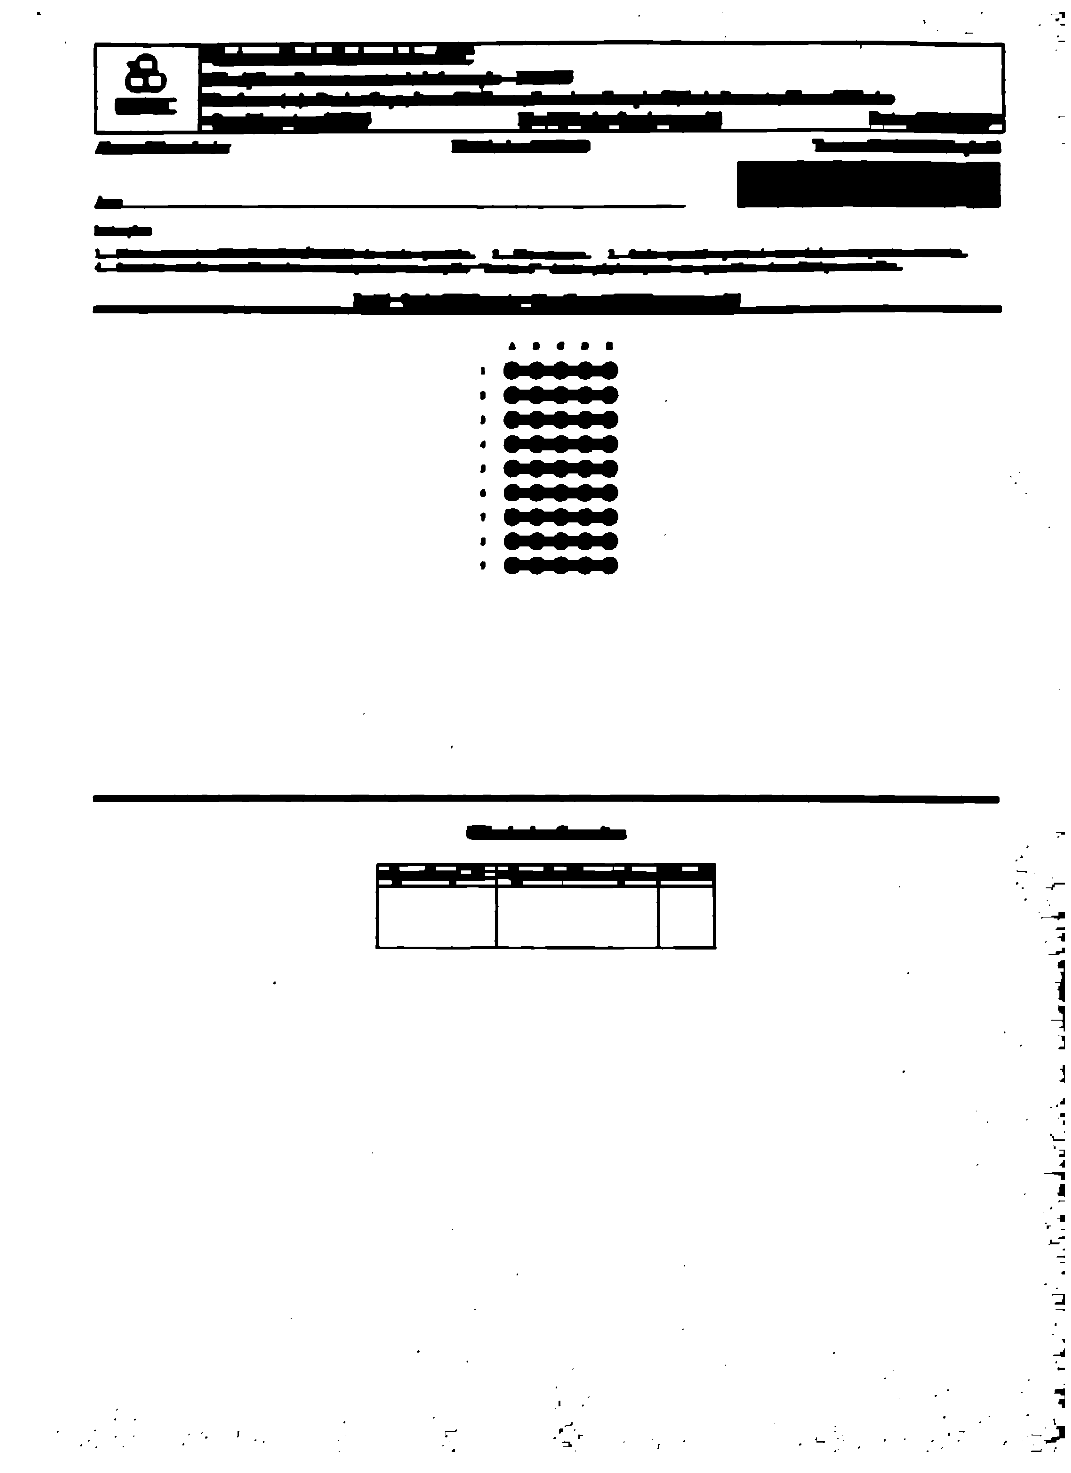

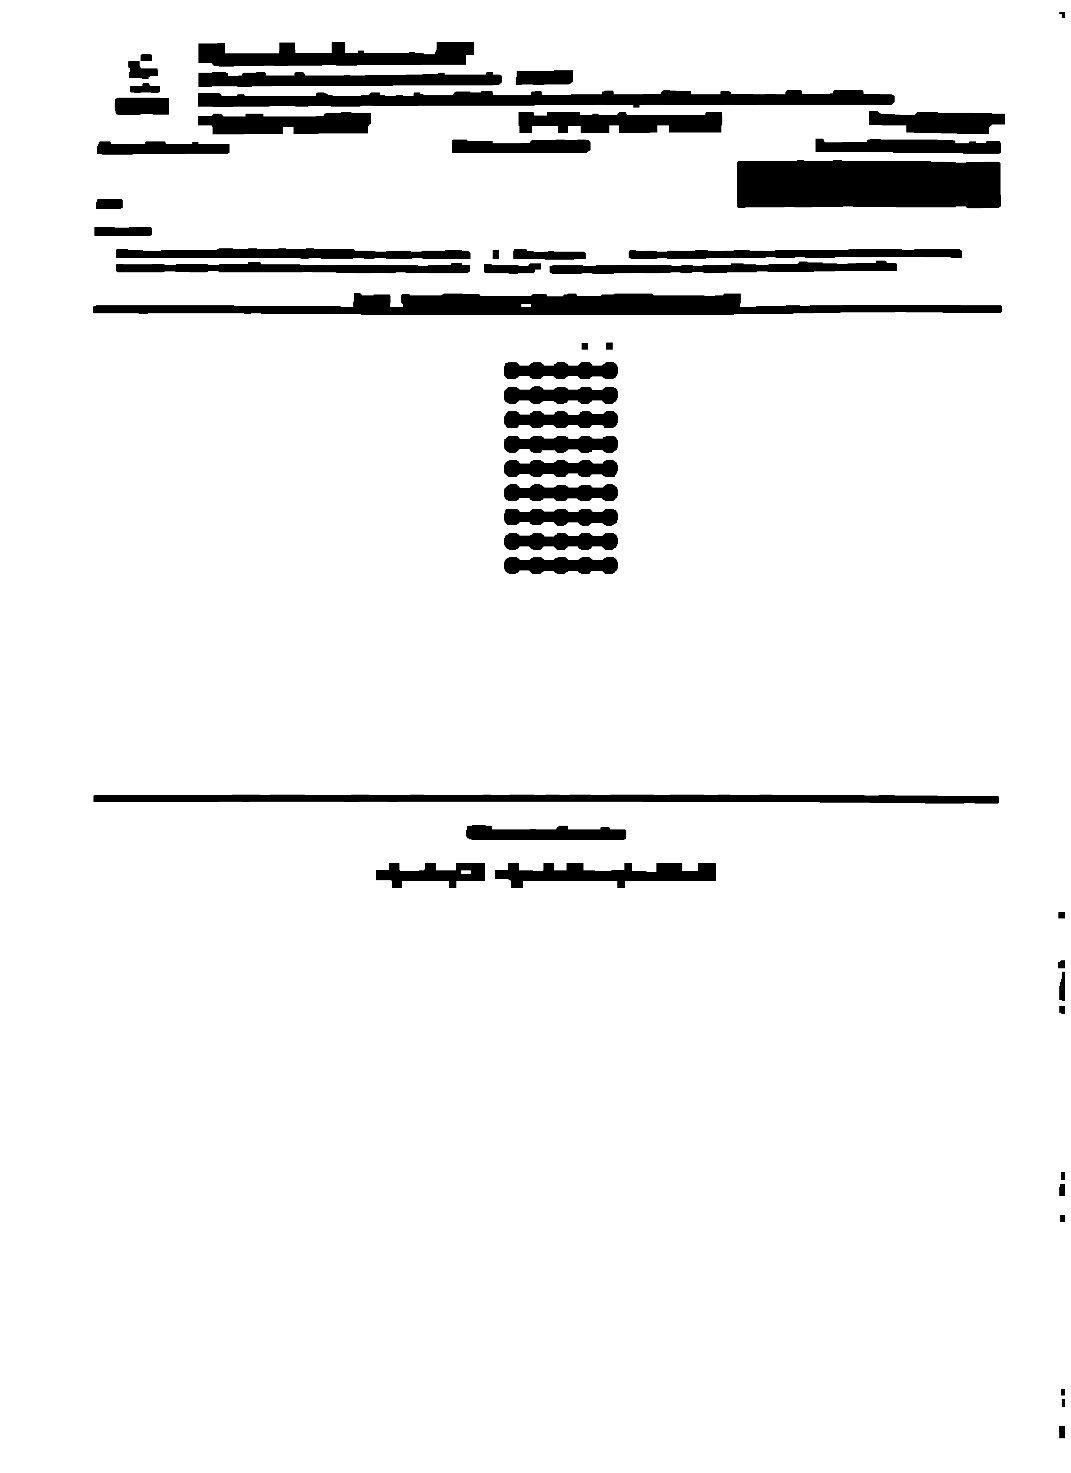

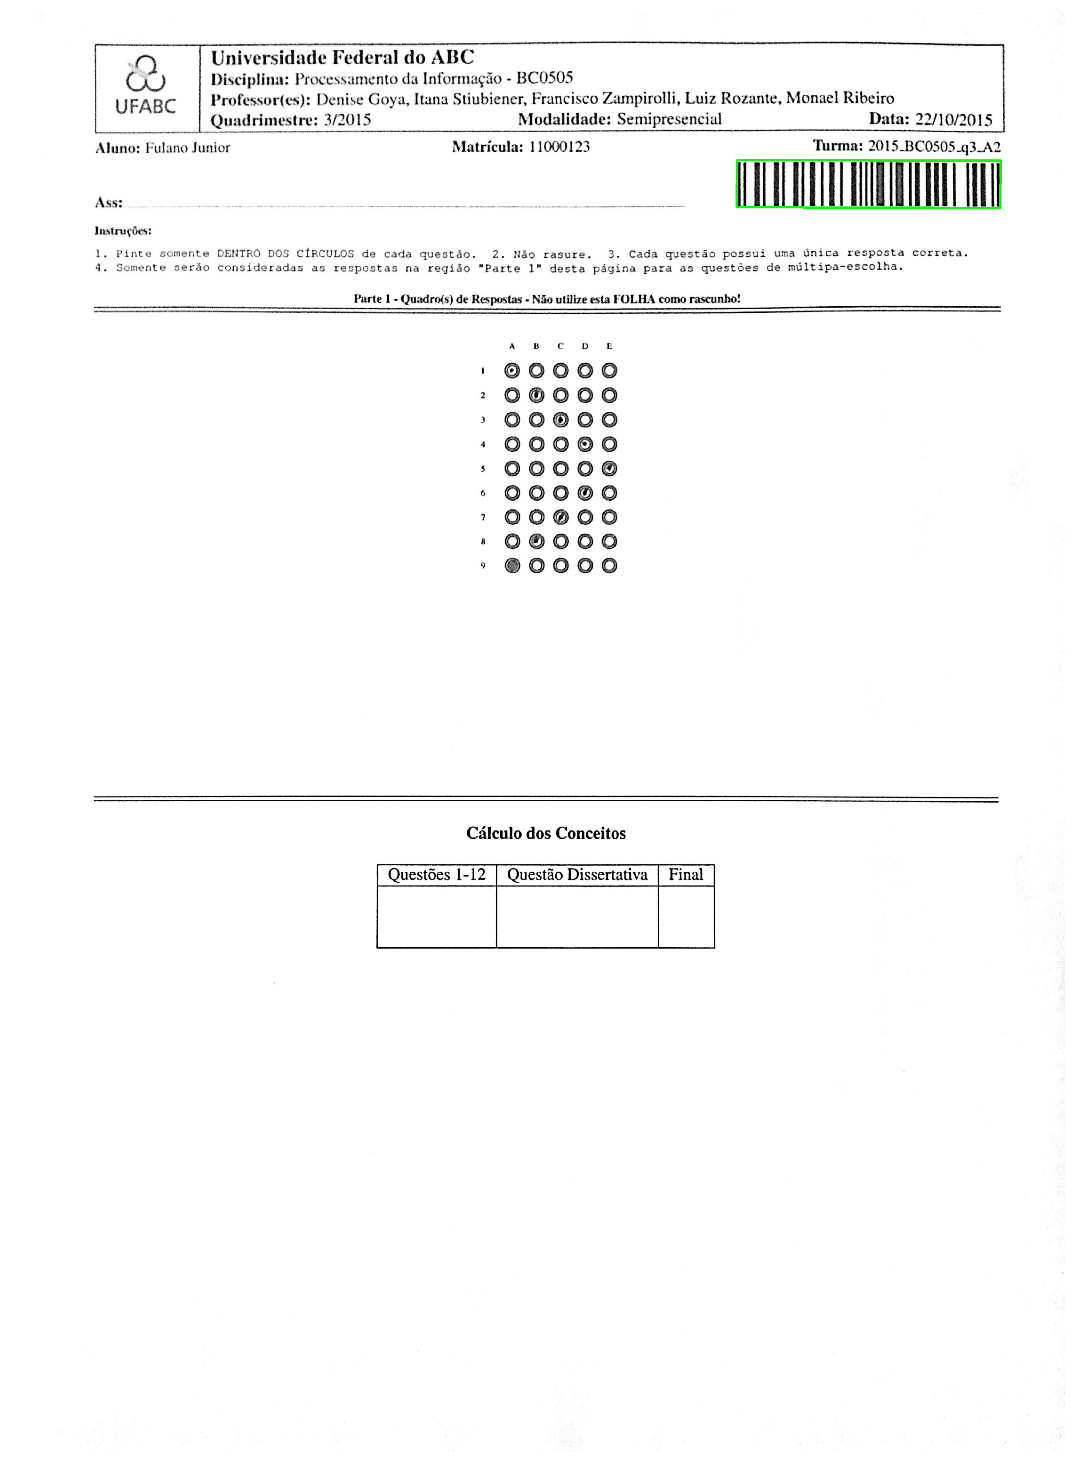

In [136]:
gray = images[1].copy()
image = cv2.cvtColor(255-gray, cv2.COLOR_GRAY2RGB)
imshow(image)

gradient = scharrGradient(gray)

imshow(gradient, cmap='Greys')

# blur and threshold the image
thresh = otsuBinary(gradient)

imshow(thresh, cmap='Greys')

closed = morphClose(thresh, (21, 7))

imshow(closed, cmap='Greys')

# perform a series of erosions and dilations
closed = cv2.erode(closed, None, iterations = 6)
closed = cv2.dilate(closed, None, iterations = 6)

imshow(closed, cmap='Greys')

# find the contours in the thresholded image, then sort the contours
# by their area, keeping only the largest one
(cntIm, cnts, _) = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
c = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
 
# compute the rotated bounding box of the largest contour
rect = cv2.minAreaRect(c)
box = np.int0(cv2.boxPoints(rect))
 
# draw a bounding box arounded the detected barcode and display the
# image
image = image
cv2.drawContours(image, [box], -1, (0, 255, 0), 3)

imshow(image)

# Referências para próxima parte:
http://www.oberhofer.co/how-barcode-localization-works-in-quaggajs/

http://docs.opencv.org/2.4/modules/ml/doc/support_vector_machines.html

http://www.computervisionblog.com/2014/11/barcodes-realtime-training-and.html

### Nota sobre tentativa com desvio padrão:
Usando o desvio padrão os resultados foram muito piores do que com k-médias. Provavelmente porque o a medida de "compactness" do agrupamento compense um pouco os desvios causados por componentes não paralelas que podem aparecer numa imagem em que paralelas predominam.

In [137]:
class Cell(object):
    def __init__(self, row, col, cellImg):
        self.img = cellImg
        self.row = row
        self.col = col
        self.hasBarcodeFeatures = False
        self.orientation = 0
        self.label = None
        self.contours = None
        self.evaluateBarcodeFeatures()
    
    def getImgContours(self):
        cntIm, cnts, hierarchy = cv2.findContours(self.img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        self.contours = cnts
        return cnts
    
    def getContourImg(self):
        if self.contours == None:
            self.getImgContours()
        cellImg = cv2.cvtColor(255-self.img, cv2.COLOR_GRAY2RGB)
        return cv2.drawContours(cellImg, self.contours, -1, (0,255,0), 3)
    
    def getSkeletonizedImage(self):
        """ OpenCV function to return a skeletonized version of img, a Mat object"""
        #  hat tip to http://felix.abecassis.me/2011/09/opencv-morphological-skeleton/
        img = self.img.copy() # don't clobber original
        skel = self.img.copy()
        skel[:,:] = 0
        kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))
        while True:
            eroded = cv2.morphologyEx(img, cv2.MORPH_ERODE, kernel)
            temp = cv2.morphologyEx(eroded, cv2.MORPH_DILATE, kernel)
            temp  = cv2.subtract(img, temp)
            skel = cv2.bitwise_or(skel, temp)
            img[:,:] = eroded[:,:]
            if cv2.countNonZero(img) == 0 or cv2.countNonZero(img) == img.size:
                break
        return skel
    
    def getSkeletonizedImgContours(self):
        skeletonized = self.getSkeletonizedImage()
        cntIm, cnts, hierarchy = cv2.findContours(skeletonized, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        self.contours = cnts
        return cnts
    
    def getContourOrientation(self, contour):
        moments = cv2.moments(contour)
        mu00 = moments['m00']
        mul11 = moments['mu11'] / mu00
        mul02 = moments['mu02'] / mu00
        mul20 = moments['mu20'] / mu00
        if (mul20 - mul02) == 0:
            return None
        try:
            angleRad = 0.5 * math.atan((2 * mul11) / (mul20 - mul02))
            return math.degrees(angleRad)
        except:
            print contour
            raise
    
    def evaluateBarcodeFeatures(self):
        if self.contours == None:
            self.getImgContours()
        
        # Filter out smaller contours which should be random noise
        sizeThresh = 30
        filteredContours = [contour for contour in self.contours if cv2.moments(contour)['m00'] > sizeThresh]
        
        # Get contour orientations
        angles = [x for x in [self.getContourOrientation(contour) for contour in filteredContours] if x != None]
        
        # Eliminate cells with a small number of valid contours
        nElements = len(angles)
        if nElements < 2:
             # cell is not part of barcode
            self.hasBarcodeFeatures = False
            return self
        
        # Use K-means clustering to determine if there is a prevalent orientation among contours
        # Define criteria = ( type, max_iter = 10 , epsilon = 0.5 )
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 0.5)
        flags = cv2.KMEANS_RANDOM_CENTERS
        clusterElements = np.float32(angles)
        compactness, labels, centers = cv2.kmeans(clusterElements,2,None,criteria,10,flags)
        
        # Smaller compactness should occur for a group of similarly oriented contours
        meanCompactness = compactness / float(len(clusterElements))
        compactnessThreshold = 1
        if meanCompactness < compactnessThreshold:
            self.hasBarcodeFeatures = True
            self.orientation = np.mean(clusterElements)
            return self
        else:
            self.hasBarcodeFeatures = False
            return self
    
    def getImageWithBorder(self, borderColor = (127, 127, 127)):
        cellImg = cv2.cvtColor(255-self.img, cv2.COLOR_GRAY2RGB)
        if borderColor == None:
            return cellImg
        cellImg[0:2,:]  = borderColor
        cellImg[:,0:2]  = borderColor
        cellImg[-2:,:] = borderColor
        cellImg[:,-2:] = borderColor
        return cellImg
    
    def getFillImage(self, fillColor = (127, 127, 127)):
        cellImg = cv2.cvtColor(255-self.img, cv2.COLOR_GRAY2RGB)
        if fillColor == None:
            return cellImg
        cellImg[:,:] = fillColor
        return cellImg
    
    def getLabelMaskImage(self, label):
        img = self.img.copy()
        if self.label == label:
            img[:,:] = 255
            return img
        else:
            img[:,:] = 0
            return img
    
    def getLabelBorderImage(self):
        if self.label != None:
            labelColor = self.label.color
            cellImg = self.getImageWithBorder(labelColor)
            return cellImg
        else:
            return self.getImageWithBorder(None)
    
    def getLabelOrientationImage(self):
        if self.label != None:
            labelColor = self.label.color
            cellImg = self.getFillImage(labelColor)
            font = cv2.FONT_HERSHEY_SIMPLEX
            textColor = (255-labelColor[0], 255-labelColor[1], 255-labelColor[2])
            cv2.putText(cellImg,str(self.orientation),(2,30), font, 0.6,textColor,2,cv2.LINE_AA)
            return cellImg
        else:
            return self.getFillImage(None)

In [138]:
class Label(object):
    def __init__(self, labelNumber, parentList):
        self.count = 0
        self.number = labelNumber
        self.parentList = parentList
        self.color = (rnd.randint(0,255), rnd.randint(0, 255), rnd.randint(0, 255))
    
    def assignTo(self, obj):
        if obj.label != None:
            raise ValueError('Trying to assign new Label to an object that already has a label.')
        obj.label = self
        self.count += 1

In [139]:
class LabelList(object):
    def __init__(self):
        self.labelList = []
    
    def getLabelCount(self):
        return len(self.labelList)
    
    def getNewLabel(self):
        newLabel = Label(self.getLabelCount(), self)
        self.labelList.append(newLabel)
        return newLabel
    
    def getCurLabel(self):
        if len(self.labelList) < 1:
            self.getNewLabel()
        return self.labelList[-1]
    
    def sortBySizeDesc(self):
        self.labelList.sort(key=lambda l: l.count, reverse=True)
    
    def getListSortedBySizeDesc(self):
        self.sortBySizeDesc()
        return self.labelList

In [140]:
class ImageGrid(object):
    def __init__(self, image, gridWidth, gridHeight):
        self.img = image.copy()
        self.width = gridWidth
        self.height = gridHeight
        tempGrid = [np.hsplit(row, gridWidth) for row in np.vsplit(self.img, gridHeight)]
        self.grid = [[Cell(rowIdx, colIdx, img) for colIdx, img in enumerate(row)] for rowIdx, row in enumerate(tempGrid)]
        self.labelList = self.labelCells()
    
    def labelCells(self):
        labelList = LabelList()
        for row in range(len(self.grid)):
            for col in range(len(self.grid[0])):
                if self.grid[row][col].label == None:
                    curLabel = labelList.getNewLabel()
                    self.recursiveLabel(row, col, curLabel)
        return labelList
    
    def calcAngleDiff(self, angle1, angle2):
        diff = abs(angle1 - angle2)
        diff = diff if diff <= 90 else (180.0 - diff)
        return diff
    
    def recursiveLabel(self, row, col, curLabel):
        gridHeight = len(self.grid)
        gridWidth = len(self.grid[0])
        angleThreshold = 3
        if row in range(gridHeight) and col in range(gridWidth):
            curCell = self.grid[row][col]
            if curCell.hasBarcodeFeatures and curCell.label == None:
                curLabel.assignTo(curCell)
                for i in range(-1, 2):
                    for j in range(-1, 2):
                        newRow = row+i
                        newCol = col+j
                        if newRow in range(gridHeight) and newCol in range(gridWidth):
                            neighbor = self.grid[newRow][newCol]
                            angleDiff = self.calcAngleDiff(curCell.orientation, neighbor.orientation)
                            if angleDiff < angleThreshold:
                                self.recursiveLabel(newRow, newCol, curLabel)
    
    def getConcatGrid(self, imgGrid):
        return np.concatenate([np.concatenate(row, axis=1) for row in imgGrid], axis=0)
    
    def getGridImage(self):
        cellImgGrid = [[cell.img for cell in row]for row in self.grid]
        return self.getConcatGrid(cellImgGrid)
    
    def getLabelBorderImage(self):
        labelImgGrid = [[cell.getLabelBorderImage() for cell in row]for row in self.grid]
        return self.getConcatGrid(labelImgGrid)
    
    def getLabelOrientationImage(self):
        labelImgGrid = [[cell.getLabelOrientationImage() for cell in row]for row in self.grid]
        return self.getConcatGrid(labelImgGrid)
    
    def getLabelMaskImage(self, label):
        labelMaskGrid = [[cell.getLabelMaskImage(label) for cell in row]for row in self.grid]
        return self.getConcatGrid(labelMaskGrid)

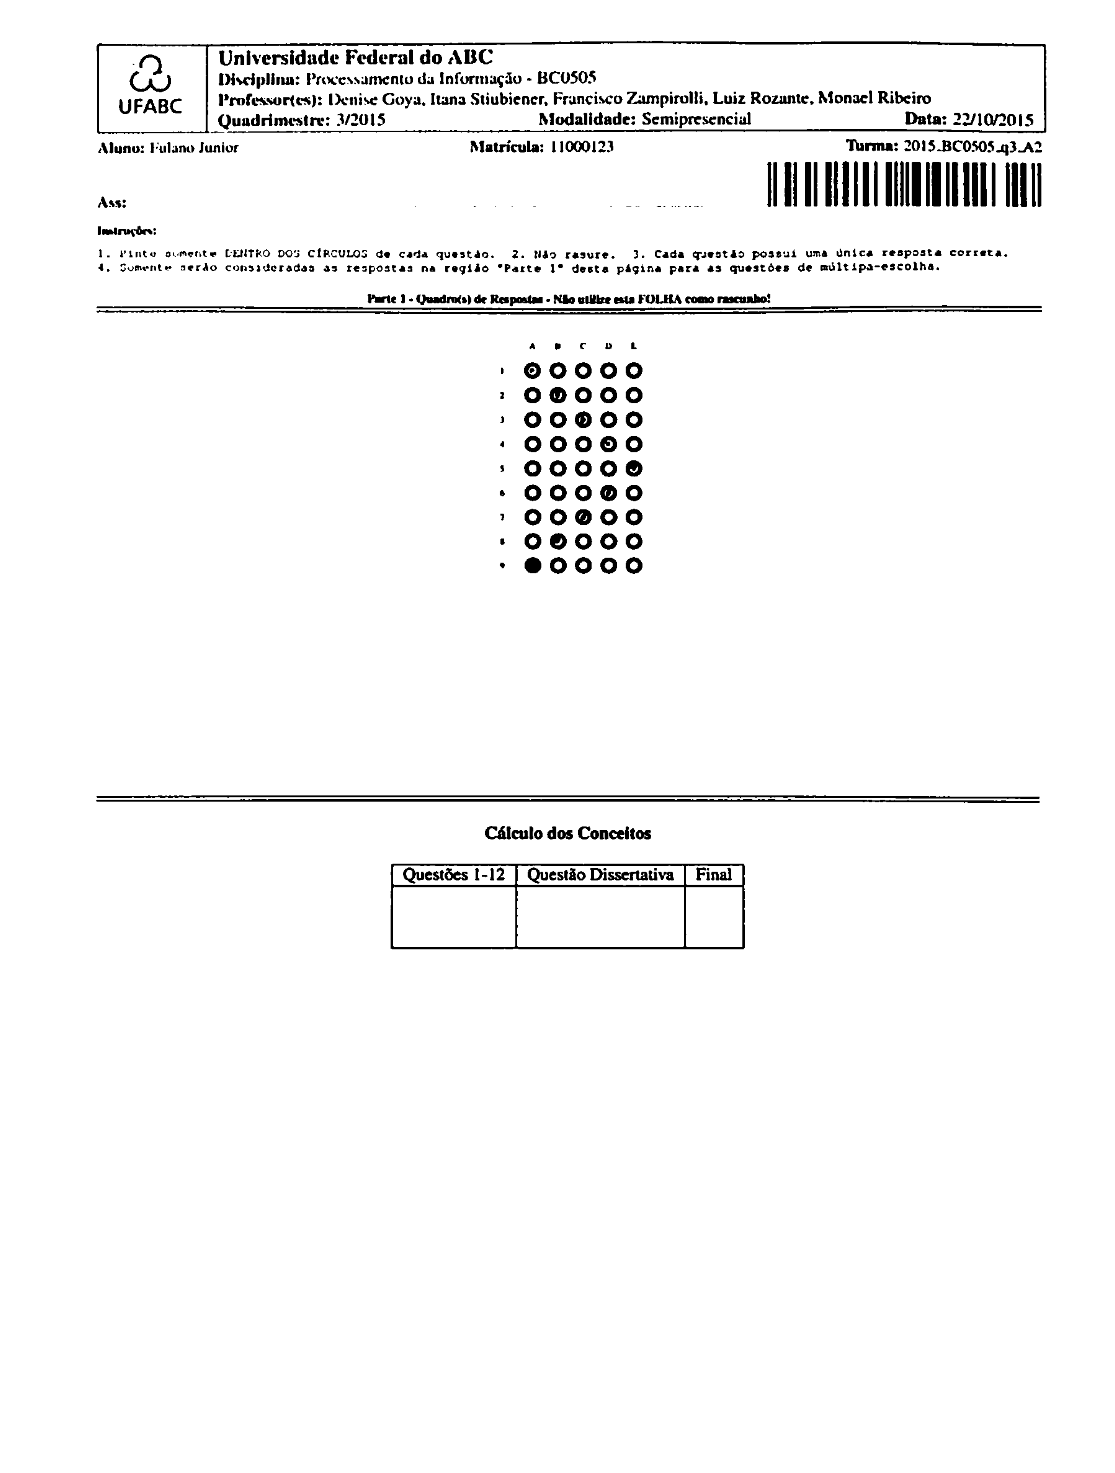

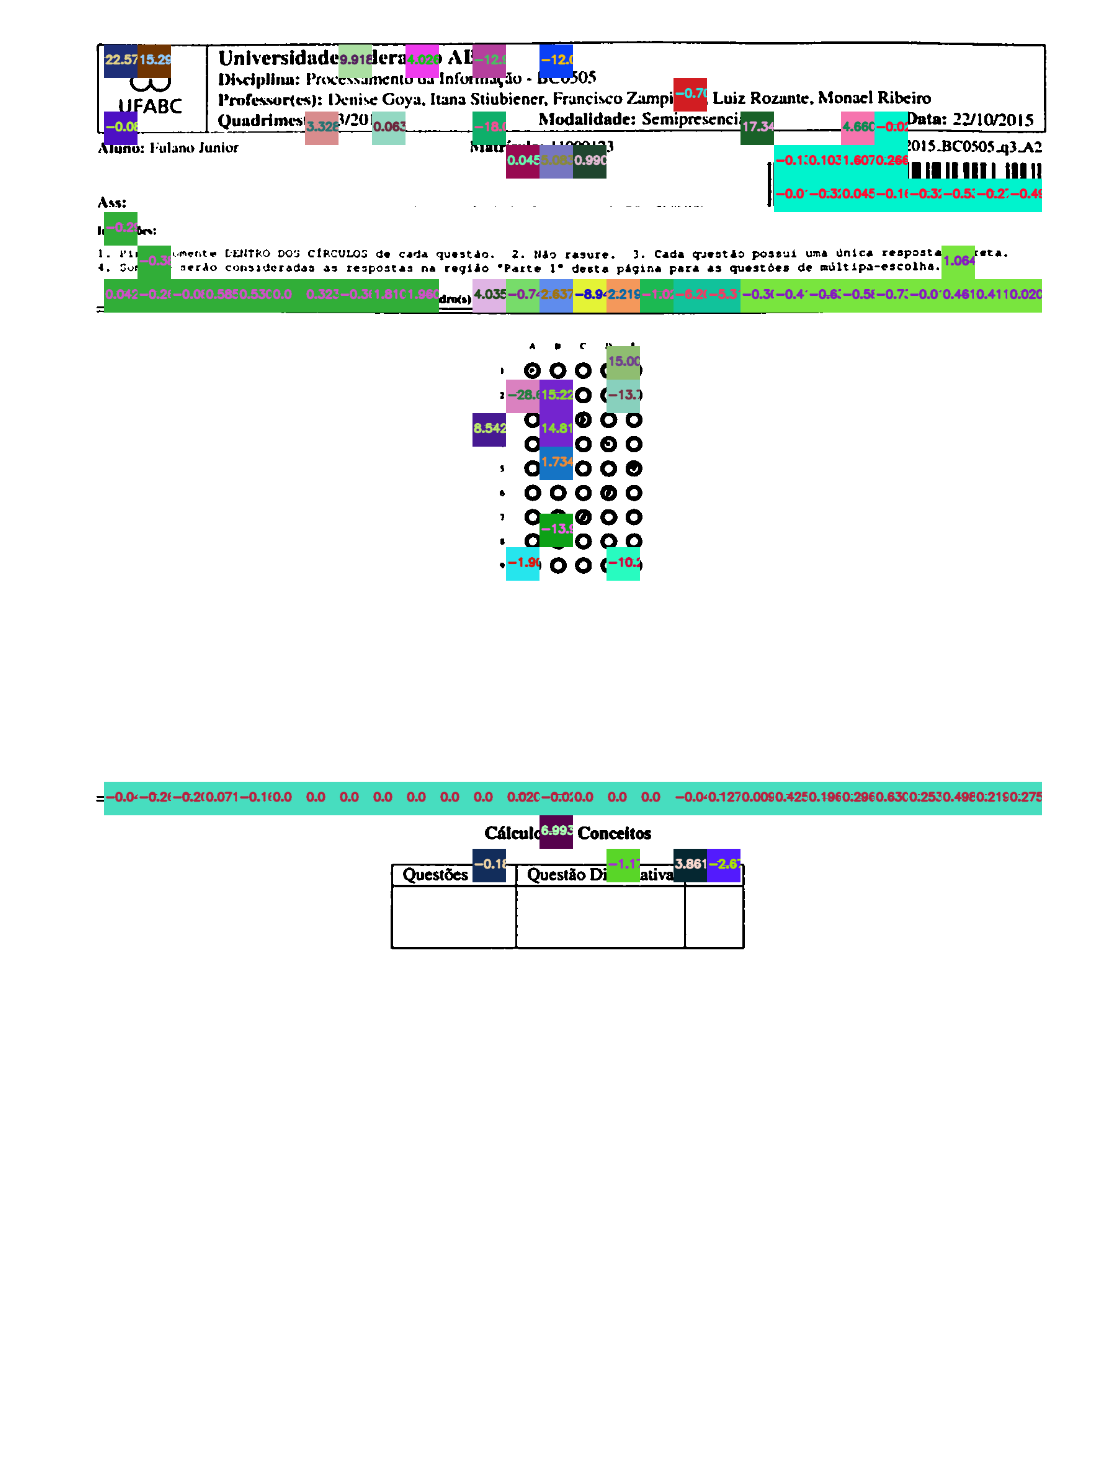

In [142]:
resizeShape = (1728, 2322)
#resizeShape = (608, 820)
rows, cols = resizeShape
image = cv2.resize(images[1], resizeShape)

M = cv2.getRotationMatrix2D((cols/2,rows/2),90,1)
#image = cv2.warpAffine(image,M,resizeShape)

rgbImage = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
binImage = otsuBinary(image)
imshow(binImage, cmap='Greys')

#grid = ImageGrid(binImage, 16, 20)
grid = ImageGrid(binImage, 32, 43)
imshow(grid.getLabelOrientationImage())